### SPEECH RECOGNITION
###### Eliud Omollo

In [63]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.utils import to_categorical 
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.models import load_model

In [2]:
import librosa
from librosa.display import specshow
from tqdm import tqdm
from scipy.io import wavfile

In [3]:
import pickle
import os

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import numpy as np

In [7]:
class GenerateData:     
    def __init__(self, lbl_dir, ds_dir, max_len):
        self.lbl_dir = lbl_dir
        self.ds_dir = ds_dir
        self.max_len = max_len
        
    def get_labels(self):        
        labels = os.listdir(self.lbl_dir)        
        return labels
    
    # Convert wave forms to mfcc
    def convert_wave_to_mfcc(self, audio_raw_path, max_len):
        audio_raw, sampling_rate = librosa.load(audio_raw_path, mono=True, sr=None)
        audio_mfcc = librosa.feature.mfcc(audio_raw, sr=sampling_rate) 
        
        #restrict all audio files to max_len
        
        # if audio file is shorter, appending with zero to max length
        if(audio_mfcc.shape[1] < max_len ):
            pad_width = max_len - audio_mfcc.shape[1]
            audio_mfcc =np.pad(array=audio_mfcc, pad_width=((0, 0), (0, pad_width)),
                               mode='constant', constant_values=((0, 0), (0, 0))) 
        else:
            #select only the first max_len samples:
            audio_mfcc = audio_mfcc[:, :max_len]
            
        return audio_mfcc
    
    # save data to file
    def save_data_to_disk(self, data, filename):
        with open(filename, 'wb') as fp:
            pickle.dump(data, fp)
            print('Saved: %s' % filename)
    
   
    # load doc into memory
    def load_file(self, filename):
        # open the file as read only
        with open(filename, mode='rb') as fn:
            data = pickle.load(fn)    
        return data
    
    def create_mfcc_dataset(self):        
        labels = self.get_labels()
        for label in labels: 
            audio_mfcc_array = []
            curr_path = os.path.join(self.lbl_dir, label)
            audio_files = os.listdir(curr_path)
            save_path = os.path.join(self.ds_dir, label)
            for audio_file in audio_files:
                full_path = os.path.join(curr_path, audio_file)
                audio_mfcc = self.convert_wave_to_mfcc(full_path, self.max_len)
                audio_mfcc_array.append(audio_mfcc)
            audio_mfcc_array = np.array(audio_mfcc_array)
            self.save_data_to_disk(audio_mfcc_array, save_path)
        print('Dataset Created Successfully')
    
    #plot mfcc    
    def plot_audio_mfcc(self, audio_mfcc):
        fig, ax = plt.subplots(figsize=(10, 4))                
        librosa.display.specshow(audio_mfcc, x_axis='time')        
        ax.set_title('MFCC')        
        return fig
    
    #load dataset   
    def load_dataset(self, test_size):
        audio_labels = self.get_labels()                       
        audio_files = [os.path.join(self.ds_dir, file) for file in audio_labels] #make a full path
        isExistFile = all([os.path.isfile(fname) for fname in audio_files])
        if not isExistFile:
            print('Creating MFCC Dataset...')
            self.create_mfcc_dataset()        
        
        #first label is assigned label 0
        audio_input = self.load_file(audio_files[0])  # loading the saved audio file        
        audio_class = np.zeros(audio_input.shape[0]) # assigning class = 0 for input 0
        
        #vertically stack and assign classes to remaining audio inputs
        
        for index, audio_file in enumerate(audio_files[1:]):
            curr_audio_file = self.load_file(audio_file) # load the next audio class
            audio_input = np.vstack((audio_input,curr_audio_file)) # stack the audio class to the array
            #assign the next class
            audio_class = np.append(audio_class, np.full(curr_audio_file.shape[0], fill_value=(index +1)))        
        assert audio_input.shape[0] == audio_class.shape[0] # check to see if dimensions add up
        audio_input = audio_input[:,:,:, np.newaxis] #add channel: change dims from (:, 20, max_len) to (:, 20, max_len, 1)

        
        #hot encode the output
        audio_class = to_categorical(audio_class) #encodes the classes
        
        #Perform train, test split        
        X_train, X_test, y_train, y_test = train_test_split(audio_input, audio_class, test_size= test_size, random_state=42)

        return X_train, X_test, y_train, y_test       

In [8]:
class GenerateModel:    
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train 
        self.y_test = y_test
        self.num_classes = y_train.shape[1]
        self.sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
        
    
    def create_model(self,model_path, batch_size=100, epochs=200, verbose =1):
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu',input_shape = self.sample_shape))
        model.add(Conv2D(filters = 48, kernel_size=(2, 2), activation='relu'))
        model.add(Conv2D(filters = 120, kernel_size=(2, 2), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate = 0.25))
        model.add(Flatten())
        model.add(Dense(units = 128, activation='relu'))
        model.add(Dropout(rate=0.25))
        model.add(Dense(units=64, activation='relu'))
        model.add(Dropout(rate=0.4))
        model.add(Dense(units=self.num_classes, activation='softmax'))
        model.compile(loss = categorical_crossentropy, optimizer = Adadelta(), metrics = ['accuracy'])
        history = model.fit(x = self.X_train, y= self.y_train, 
                  batch_size = batch_size, 
                  epochs = epochs,
                  verbose=verbose,
                  validation_data = (self.X_test, self.y_test))        
        self.model_path = model_path
        self.history = history
        model.save(self.model_path)
        
    
    def plot_accuracy(self):
        history = self.history
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    
    def make_predictions(self,fn,lbl_dir, max_len = 11):
        gen_data = GenerateData(lbl_dir = lbl_dir, ds_dir = None, max_len=max_len)        
        test_audio = gen_data.convert_wave_to_mfcc(fn, max_len)
        test_audio = test_audio[np.newaxis, :,:,np.newaxis]
        model = load_model(self.model_path)
        pred = np.argmax(model.predict(test_audio))
        pred_class = gen_data.get_labels()[pred]        
        print('Model Predicted: ', pred_class)       
        

In [9]:
DATA_PATH = 'data'
SAVE_PATH = 'saved-data'
MODEL = 'models/model.h5'

In [10]:
dataset = GenerateData(lbl_dir =DATA_PATH, ds_dir = SAVE_PATH, max_len= 30 )
X_train, X_test, y_train, y_test  = dataset.load_dataset(test_size=0.25)
model = GenerateModel(X_train, X_test, y_train, y_test)
model.create_model(model_path= MODEL, epochs=200)

Train on 6989 samples, validate on 2330 samples
Epoch 1/200
6989/6989 [==============================] - ETA: 4:17 - loss: 6.5236 - acc: 0.140 - ETA: 1:24 - loss: 10.1576 - acc: 0.14 - ETA: 50s - loss: 9.7266 - acc: 0.1800 - ETA: 35s - loss: 8.8635 - acc: 0.18 - ETA: 27s - loss: 7.3550 - acc: 0.18 - ETA: 21s - loss: 6.3008 - acc: 0.21 - ETA: 18s - loss: 5.5594 - acc: 0.24 - ETA: 15s - loss: 5.0170 - acc: 0.26 - ETA: 13s - loss: 4.5948 - acc: 0.27 - ETA: 11s - loss: 4.2580 - acc: 0.29 - ETA: 10s - loss: 3.9814 - acc: 0.30 - ETA: 9s - loss: 3.7548 - acc: 0.3187 - ETA: 8s - loss: 3.5535 - acc: 0.334 - ETA: 7s - loss: 3.3739 - acc: 0.353 - ETA: 6s - loss: 3.2230 - acc: 0.365 - ETA: 6s - loss: 3.0957 - acc: 0.373 - ETA: 5s - loss: 2.9766 - acc: 0.382 - ETA: 4s - loss: 2.8736 - acc: 0.391 - ETA: 4s - loss: 2.7678 - acc: 0.404 - ETA: 4s - loss: 2.6822 - acc: 0.412 - ETA: 3s - loss: 2.6063 - acc: 0.420 - ETA: 3s - loss: 2.5403 - acc: 0.425 - ETA: 2s - loss: 2.4752 - acc: 0.432 - ETA: 2s - loss

6989/6989 [==============================] - ETA: 2s - loss: 0.1141 - acc: 0.980 - ETA: 2s - loss: 0.1660 - acc: 0.943 - ETA: 2s - loss: 0.2029 - acc: 0.936 - ETA: 2s - loss: 0.1927 - acc: 0.940 - ETA: 2s - loss: 0.1793 - acc: 0.942 - ETA: 2s - loss: 0.1810 - acc: 0.940 - ETA: 2s - loss: 0.1872 - acc: 0.938 - ETA: 1s - loss: 0.1916 - acc: 0.937 - ETA: 1s - loss: 0.1899 - acc: 0.938 - ETA: 1s - loss: 0.1850 - acc: 0.939 - ETA: 1s - loss: 0.1795 - acc: 0.941 - ETA: 1s - loss: 0.1767 - acc: 0.942 - ETA: 1s - loss: 0.1729 - acc: 0.943 - ETA: 1s - loss: 0.1763 - acc: 0.943 - ETA: 1s - loss: 0.1764 - acc: 0.942 - ETA: 1s - loss: 0.1746 - acc: 0.943 - ETA: 1s - loss: 0.1736 - acc: 0.943 - ETA: 1s - loss: 0.1737 - acc: 0.943 - ETA: 1s - loss: 0.1814 - acc: 0.940 - ETA: 1s - loss: 0.1817 - acc: 0.940 - ETA: 1s - loss: 0.1844 - acc: 0.939 - ETA: 0s - loss: 0.1822 - acc: 0.940 - ETA: 0s - loss: 0.1814 - acc: 0.940 - ETA: 0s - loss: 0.1801 - acc: 0.940 - ETA: 0s - loss: 0.1824 - acc: 0.939 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0672 - acc: 0.970 - ETA: 2s - loss: 0.0624 - acc: 0.973 - ETA: 2s - loss: 0.0618 - acc: 0.978 - ETA: 2s - loss: 0.0734 - acc: 0.977 - ETA: 2s - loss: 0.0612 - acc: 0.982 - ETA: 2s - loss: 0.0551 - acc: 0.985 - ETA: 2s - loss: 0.0519 - acc: 0.985 - ETA: 2s - loss: 0.0535 - acc: 0.984 - ETA: 2s - loss: 0.0551 - acc: 0.984 - ETA: 1s - loss: 0.0636 - acc: 0.981 - ETA: 1s - loss: 0.0647 - acc: 0.980 - ETA: 1s - loss: 0.0628 - acc: 0.981 - ETA: 1s - loss: 0.0621 - acc: 0.981 - ETA: 1s - loss: 0.0605 - acc: 0.981 - ETA: 1s - loss: 0.0613 - acc: 0.980 - ETA: 1s - loss: 0.0642 - acc: 0.978 - ETA: 1s - loss: 0.0621 - acc: 0.980 - ETA: 1s - loss: 0.0617 - acc: 0.980 - ETA: 1s - loss: 0.0615 - acc: 0.980 - ETA: 1s - loss: 0.0618 - acc: 0.980 - ETA: 1s - loss: 0.0635 - acc: 0.980 - ETA: 1s - loss: 0.0633 - acc: 0.980 - ETA: 0s - loss: 0.0625 - acc: 0.980 - ETA: 0s - loss: 0.0621 - acc: 0.980 - ETA: 0s - loss: 0.0615 - acc: 0.981 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0196 - acc: 0.990 - ETA: 2s - loss: 0.0244 - acc: 0.986 - ETA: 2s - loss: 0.0288 - acc: 0.986 - ETA: 2s - loss: 0.0224 - acc: 0.990 - ETA: 2s - loss: 0.0300 - acc: 0.988 - ETA: 2s - loss: 0.0267 - acc: 0.990 - ETA: 2s - loss: 0.0403 - acc: 0.988 - ETA: 1s - loss: 0.0383 - acc: 0.989 - ETA: 1s - loss: 0.0389 - acc: 0.989 - ETA: 1s - loss: 0.0425 - acc: 0.988 - ETA: 1s - loss: 0.0396 - acc: 0.990 - ETA: 1s - loss: 0.0370 - acc: 0.990 - ETA: 1s - loss: 0.0407 - acc: 0.989 - ETA: 1s - loss: 0.0405 - acc: 0.989 - ETA: 1s - loss: 0.0396 - acc: 0.989 - ETA: 1s - loss: 0.0376 - acc: 0.990 - ETA: 1s - loss: 0.0362 - acc: 0.990 - ETA: 1s - loss: 0.0384 - acc: 0.990 - ETA: 1s - loss: 0.0387 - acc: 0.989 - ETA: 1s - loss: 0.0392 - acc: 0.989 - ETA: 1s - loss: 0.0393 - acc: 0.989 - ETA: 0s - loss: 0.0414 - acc: 0.989 - ETA: 0s - loss: 0.0404 - acc: 0.989 - ETA: 0s - loss: 0.0401 - acc: 0.989 - ETA: 0s - loss: 0.0414 - acc: 0.989 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0040 - acc: 1.000 - ETA: 2s - loss: 0.0190 - acc: 0.993 - ETA: 2s - loss: 0.0243 - acc: 0.990 - ETA: 2s - loss: 0.0249 - acc: 0.991 - ETA: 2s - loss: 0.0299 - acc: 0.988 - ETA: 2s - loss: 0.0286 - acc: 0.989 - ETA: 2s - loss: 0.0325 - acc: 0.989 - ETA: 1s - loss: 0.0359 - acc: 0.988 - ETA: 1s - loss: 0.0347 - acc: 0.988 - ETA: 1s - loss: 0.0316 - acc: 0.990 - ETA: 1s - loss: 0.0299 - acc: 0.990 - ETA: 1s - loss: 0.0287 - acc: 0.990 - ETA: 1s - loss: 0.0265 - acc: 0.991 - ETA: 1s - loss: 0.0256 - acc: 0.991 - ETA: 1s - loss: 0.0244 - acc: 0.991 - ETA: 1s - loss: 0.0255 - acc: 0.991 - ETA: 1s - loss: 0.0249 - acc: 0.991 - ETA: 1s - loss: 0.0239 - acc: 0.992 - ETA: 1s - loss: 0.0251 - acc: 0.991 - ETA: 1s - loss: 0.0251 - acc: 0.991 - ETA: 1s - loss: 0.0243 - acc: 0.991 - ETA: 0s - loss: 0.0240 - acc: 0.991 - ETA: 0s - loss: 0.0243 - acc: 0.991 - ETA: 0s - loss: 0.0271 - acc: 0.990 - ETA: 0s - loss: 0.0268 - acc: 0.990 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0039 - acc: 1.000 - ETA: 2s - loss: 0.0081 - acc: 1.000 - ETA: 2s - loss: 0.0197 - acc: 0.994 - ETA: 2s - loss: 0.0164 - acc: 0.994 - ETA: 2s - loss: 0.0212 - acc: 0.994 - ETA: 2s - loss: 0.0184 - acc: 0.995 - ETA: 2s - loss: 0.0184 - acc: 0.995 - ETA: 1s - loss: 0.0161 - acc: 0.996 - ETA: 1s - loss: 0.0182 - acc: 0.995 - ETA: 1s - loss: 0.0183 - acc: 0.995 - ETA: 1s - loss: 0.0196 - acc: 0.994 - ETA: 1s - loss: 0.0186 - acc: 0.994 - ETA: 1s - loss: 0.0210 - acc: 0.994 - ETA: 1s - loss: 0.0202 - acc: 0.994 - ETA: 1s - loss: 0.0215 - acc: 0.994 - ETA: 1s - loss: 0.0249 - acc: 0.993 - ETA: 1s - loss: 0.0242 - acc: 0.993 - ETA: 1s - loss: 0.0232 - acc: 0.994 - ETA: 1s - loss: 0.0237 - acc: 0.993 - ETA: 1s - loss: 0.0233 - acc: 0.993 - ETA: 1s - loss: 0.0222 - acc: 0.993 - ETA: 0s - loss: 0.0235 - acc: 0.994 - ETA: 0s - loss: 0.0244 - acc: 0.993 - ETA: 0s - loss: 0.0236 - acc: 0.993 - ETA: 0s - loss: 0.0237 - acc: 0.993 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0905 - acc: 0.980 - ETA: 2s - loss: 0.0335 - acc: 0.990 - ETA: 2s - loss: 0.0275 - acc: 0.990 - ETA: 2s - loss: 0.0244 - acc: 0.991 - ETA: 2s - loss: 0.0202 - acc: 0.993 - ETA: 2s - loss: 0.0211 - acc: 0.992 - ETA: 2s - loss: 0.0246 - acc: 0.993 - ETA: 1s - loss: 0.0226 - acc: 0.993 - ETA: 1s - loss: 0.0203 - acc: 0.994 - ETA: 1s - loss: 0.0190 - acc: 0.994 - ETA: 1s - loss: 0.0179 - acc: 0.995 - ETA: 1s - loss: 0.0177 - acc: 0.995 - ETA: 1s - loss: 0.0164 - acc: 0.995 - ETA: 1s - loss: 0.0167 - acc: 0.995 - ETA: 1s - loss: 0.0160 - acc: 0.995 - ETA: 1s - loss: 0.0156 - acc: 0.995 - ETA: 1s - loss: 0.0147 - acc: 0.996 - ETA: 1s - loss: 0.0139 - acc: 0.996 - ETA: 1s - loss: 0.0132 - acc: 0.996 - ETA: 1s - loss: 0.0127 - acc: 0.996 - ETA: 1s - loss: 0.0124 - acc: 0.996 - ETA: 0s - loss: 0.0130 - acc: 0.996 - ETA: 0s - loss: 0.0135 - acc: 0.996 - ETA: 0s - loss: 0.0131 - acc: 0.996 - ETA: 0s - loss: 0.0138 - acc: 0.996 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0098 - acc: 0.990 - ETA: 2s - loss: 0.0123 - acc: 0.993 - ETA: 2s - loss: 0.0080 - acc: 0.996 - ETA: 2s - loss: 0.0228 - acc: 0.991 - ETA: 2s - loss: 0.0249 - acc: 0.991 - ETA: 2s - loss: 0.0316 - acc: 0.991 - ETA: 2s - loss: 0.0334 - acc: 0.991 - ETA: 2s - loss: 0.0332 - acc: 0.991 - ETA: 1s - loss: 0.0303 - acc: 0.991 - ETA: 1s - loss: 0.0277 - acc: 0.992 - ETA: 1s - loss: 0.0313 - acc: 0.991 - ETA: 1s - loss: 0.0298 - acc: 0.992 - ETA: 1s - loss: 0.0293 - acc: 0.992 - ETA: 1s - loss: 0.0274 - acc: 0.993 - ETA: 1s - loss: 0.0269 - acc: 0.993 - ETA: 1s - loss: 0.0274 - acc: 0.992 - ETA: 1s - loss: 0.0264 - acc: 0.993 - ETA: 1s - loss: 0.0252 - acc: 0.993 - ETA: 1s - loss: 0.0256 - acc: 0.993 - ETA: 1s - loss: 0.0243 - acc: 0.993 - ETA: 1s - loss: 0.0238 - acc: 0.993 - ETA: 0s - loss: 0.0230 - acc: 0.994 - ETA: 0s - loss: 0.0225 - acc: 0.994 - ETA: 0s - loss: 0.0220 - acc: 0.994 - ETA: 0s - loss: 0.0231 - acc: 0.993 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0028 - acc: 1.000 - ETA: 2s - loss: 0.0012 - acc: 1.000 - ETA: 2s - loss: 0.0049 - acc: 0.998 - ETA: 2s - loss: 0.0081 - acc: 0.997 - ETA: 2s - loss: 0.0065 - acc: 0.997 - ETA: 2s - loss: 0.0055 - acc: 0.998 - ETA: 2s - loss: 0.0101 - acc: 0.996 - ETA: 2s - loss: 0.0135 - acc: 0.996 - ETA: 1s - loss: 0.0149 - acc: 0.995 - ETA: 1s - loss: 0.0144 - acc: 0.995 - ETA: 1s - loss: 0.0132 - acc: 0.995 - ETA: 1s - loss: 0.0151 - acc: 0.995 - ETA: 1s - loss: 0.0143 - acc: 0.995 - ETA: 1s - loss: 0.0157 - acc: 0.994 - ETA: 1s - loss: 0.0147 - acc: 0.995 - ETA: 1s - loss: 0.0143 - acc: 0.995 - ETA: 1s - loss: 0.0156 - acc: 0.994 - ETA: 1s - loss: 0.0147 - acc: 0.995 - ETA: 1s - loss: 0.0141 - acc: 0.995 - ETA: 1s - loss: 0.0139 - acc: 0.995 - ETA: 1s - loss: 0.0132 - acc: 0.995 - ETA: 1s - loss: 0.0127 - acc: 0.996 - ETA: 0s - loss: 0.0123 - acc: 0.996 - ETA: 0s - loss: 0.0118 - acc: 0.996 - ETA: 0s - loss: 0.0114 - acc: 0.996 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0012 - acc: 1.000 - ETA: 2s - loss: 0.0041 - acc: 1.000 - ETA: 2s - loss: 0.0026 - acc: 1.000 - ETA: 2s - loss: 0.0026 - acc: 1.000 - ETA: 2s - loss: 0.0021 - acc: 1.000 - ETA: 2s - loss: 0.0037 - acc: 0.999 - ETA: 2s - loss: 0.0033 - acc: 0.999 - ETA: 2s - loss: 0.0036 - acc: 0.998 - ETA: 1s - loss: 0.0047 - acc: 0.998 - ETA: 1s - loss: 0.0045 - acc: 0.998 - ETA: 1s - loss: 0.0057 - acc: 0.998 - ETA: 1s - loss: 0.0057 - acc: 0.998 - ETA: 1s - loss: 0.0054 - acc: 0.998 - ETA: 1s - loss: 0.0079 - acc: 0.997 - ETA: 1s - loss: 0.0075 - acc: 0.997 - ETA: 1s - loss: 0.0152 - acc: 0.996 - ETA: 1s - loss: 0.0149 - acc: 0.996 - ETA: 1s - loss: 0.0142 - acc: 0.996 - ETA: 1s - loss: 0.0137 - acc: 0.996 - ETA: 1s - loss: 0.0132 - acc: 0.996 - ETA: 1s - loss: 0.0126 - acc: 0.997 - ETA: 1s - loss: 0.0121 - acc: 0.997 - ETA: 0s - loss: 0.0134 - acc: 0.996 - ETA: 0s - loss: 0.0131 - acc: 0.996 - ETA: 0s - loss: 0.0127 - acc: 0.996 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 7.8632e-05 - acc: 1.000 - ETA: 2s - loss: 0.0282 - acc: 0.9933    - ETA: 2s - loss: 0.0170 - acc: 0.996 - ETA: 2s - loss: 0.0131 - acc: 0.997 - ETA: 2s - loss: 0.0103 - acc: 0.997 - ETA: 2s - loss: 0.0111 - acc: 0.997 - ETA: 2s - loss: 0.0095 - acc: 0.997 - ETA: 2s - loss: 0.0097 - acc: 0.997 - ETA: 2s - loss: 0.0102 - acc: 0.996 - ETA: 1s - loss: 0.0102 - acc: 0.996 - ETA: 1s - loss: 0.0093 - acc: 0.997 - ETA: 1s - loss: 0.0086 - acc: 0.997 - ETA: 1s - loss: 0.0079 - acc: 0.997 - ETA: 1s - loss: 0.0075 - acc: 0.997 - ETA: 1s - loss: 0.0074 - acc: 0.997 - ETA: 1s - loss: 0.0071 - acc: 0.998 - ETA: 1s - loss: 0.0069 - acc: 0.998 - ETA: 1s - loss: 0.0066 - acc: 0.998 - ETA: 1s - loss: 0.0063 - acc: 0.998 - ETA: 1s - loss: 0.0060 - acc: 0.998 - ETA: 1s - loss: 0.0057 - acc: 0.998 - ETA: 1s - loss: 0.0058 - acc: 0.998 - ETA: 1s - loss: 0.0063 - acc: 0.997 - ETA: 0s - loss: 0.0064 - acc: 0.997 - ETA: 0s - loss: 0.0061 - acc: 0.997

6989/6989 [==============================] - ETA: 2s - loss: 0.0264 - acc: 0.990 - ETA: 2s - loss: 0.0220 - acc: 0.986 - ETA: 2s - loss: 0.0142 - acc: 0.992 - ETA: 2s - loss: 0.0140 - acc: 0.991 - ETA: 2s - loss: 0.0116 - acc: 0.993 - ETA: 2s - loss: 0.0136 - acc: 0.993 - ETA: 2s - loss: 0.0121 - acc: 0.994 - ETA: 2s - loss: 0.0105 - acc: 0.995 - ETA: 1s - loss: 0.0103 - acc: 0.995 - ETA: 1s - loss: 0.0093 - acc: 0.995 - ETA: 1s - loss: 0.0085 - acc: 0.996 - ETA: 1s - loss: 0.0080 - acc: 0.996 - ETA: 1s - loss: 0.0074 - acc: 0.996 - ETA: 1s - loss: 0.0073 - acc: 0.996 - ETA: 1s - loss: 0.0069 - acc: 0.996 - ETA: 1s - loss: 0.0068 - acc: 0.996 - ETA: 1s - loss: 0.0064 - acc: 0.997 - ETA: 1s - loss: 0.0061 - acc: 0.997 - ETA: 1s - loss: 0.0061 - acc: 0.997 - ETA: 1s - loss: 0.0071 - acc: 0.996 - ETA: 1s - loss: 0.0100 - acc: 0.996 - ETA: 1s - loss: 0.0095 - acc: 0.996 - ETA: 0s - loss: 0.0101 - acc: 0.996 - ETA: 0s - loss: 0.0098 - acc: 0.996 - ETA: 0s - loss: 0.0096 - acc: 0.996 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0011 - acc: 1.000 - ETA: 2s - loss: 0.0055 - acc: 1.000 - ETA: 2s - loss: 0.0045 - acc: 1.000 - ETA: 2s - loss: 0.0048 - acc: 0.998 - ETA: 2s - loss: 0.0052 - acc: 0.997 - ETA: 2s - loss: 0.0045 - acc: 0.998 - ETA: 2s - loss: 0.0039 - acc: 0.998 - ETA: 2s - loss: 0.0034 - acc: 0.998 - ETA: 1s - loss: 0.0046 - acc: 0.998 - ETA: 1s - loss: 0.0042 - acc: 0.998 - ETA: 1s - loss: 0.0076 - acc: 0.998 - ETA: 1s - loss: 0.0139 - acc: 0.997 - ETA: 1s - loss: 0.0128 - acc: 0.998 - ETA: 1s - loss: 0.0129 - acc: 0.997 - ETA: 1s - loss: 0.0121 - acc: 0.997 - ETA: 1s - loss: 0.0114 - acc: 0.997 - ETA: 1s - loss: 0.0107 - acc: 0.997 - ETA: 1s - loss: 0.0108 - acc: 0.997 - ETA: 1s - loss: 0.0126 - acc: 0.997 - ETA: 1s - loss: 0.0120 - acc: 0.997 - ETA: 1s - loss: 0.0116 - acc: 0.997 - ETA: 1s - loss: 0.0111 - acc: 0.997 - ETA: 0s - loss: 0.0106 - acc: 0.997 - ETA: 0s - loss: 0.0102 - acc: 0.997 - ETA: 0s - loss: 0.0100 - acc: 0.997 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0014 - acc: 1.000 - ETA: 2s - loss: 0.0016 - acc: 1.000 - ETA: 2s - loss: 0.0010 - acc: 1.000 - ETA: 2s - loss: 0.0080 - acc: 0.998 - ETA: 2s - loss: 0.0063 - acc: 0.998 - ETA: 2s - loss: 0.0052 - acc: 0.999 - ETA: 2s - loss: 0.0128 - acc: 0.996 - ETA: 2s - loss: 0.0230 - acc: 0.996 - ETA: 1s - loss: 0.0220 - acc: 0.995 - ETA: 1s - loss: 0.0206 - acc: 0.995 - ETA: 1s - loss: 0.0226 - acc: 0.995 - ETA: 1s - loss: 0.0208 - acc: 0.995 - ETA: 1s - loss: 0.0192 - acc: 0.996 - ETA: 1s - loss: 0.0178 - acc: 0.996 - ETA: 1s - loss: 0.0166 - acc: 0.996 - ETA: 1s - loss: 0.0158 - acc: 0.996 - ETA: 1s - loss: 0.0149 - acc: 0.997 - ETA: 1s - loss: 0.0144 - acc: 0.997 - ETA: 1s - loss: 0.0138 - acc: 0.997 - ETA: 1s - loss: 0.0132 - acc: 0.997 - ETA: 1s - loss: 0.0132 - acc: 0.997 - ETA: 0s - loss: 0.0143 - acc: 0.997 - ETA: 0s - loss: 0.0139 - acc: 0.997 - ETA: 0s - loss: 0.0134 - acc: 0.997 - ETA: 0s - loss: 0.0131 - acc: 0.997 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 0.0030 - acc: 1.000 - ETA: 2s - loss: 0.0011 - acc: 1.000 - ETA: 2s - loss: 0.0026 - acc: 0.998 - ETA: 2s - loss: 0.0050 - acc: 0.997 - ETA: 2s - loss: 0.0040 - acc: 0.997 - ETA: 2s - loss: 0.0037 - acc: 0.998 - ETA: 2s - loss: 0.0126 - acc: 0.996 - ETA: 1s - loss: 0.0111 - acc: 0.997 - ETA: 1s - loss: 0.0103 - acc: 0.997 - ETA: 1s - loss: 0.0093 - acc: 0.997 - ETA: 1s - loss: 0.0084 - acc: 0.997 - ETA: 1s - loss: 0.0077 - acc: 0.997 - ETA: 1s - loss: 0.0082 - acc: 0.997 - ETA: 1s - loss: 0.0090 - acc: 0.997 - ETA: 1s - loss: 0.0085 - acc: 0.997 - ETA: 1s - loss: 0.0080 - acc: 0.997 - ETA: 1s - loss: 0.0077 - acc: 0.997 - ETA: 1s - loss: 0.0090 - acc: 0.997 - ETA: 1s - loss: 0.0085 - acc: 0.997 - ETA: 1s - loss: 0.0081 - acc: 0.997 - ETA: 1s - loss: 0.0080 - acc: 0.998 - ETA: 0s - loss: 0.0090 - acc: 0.997 - ETA: 0s - loss: 0.0086 - acc: 0.998 - ETA: 0s - loss: 0.0083 - acc: 0.998 - ETA: 0s - loss: 0.0080 - acc: 0.998 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 1.6343e-04 - acc: 1.000 - ETA: 2s - loss: 6.8411e-04 - acc: 1.000 - ETA: 2s - loss: 0.0035 - acc: 0.9980    - ETA: 2s - loss: 0.0061 - acc: 0.997 - ETA: 2s - loss: 0.0048 - acc: 0.997 - ETA: 2s - loss: 0.0051 - acc: 0.998 - ETA: 2s - loss: 0.0058 - acc: 0.997 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0139 - acc: 0.997 - ETA: 1s - loss: 0.0128 - acc: 0.997 - ETA: 1s - loss: 0.0134 - acc: 0.997 - ETA: 1s - loss: 0.0142 - acc: 0.996 - ETA: 1s - loss: 0.0139 - acc: 0.996 - ETA: 1s - loss: 0.0130 - acc: 0.996 - ETA: 1s - loss: 0.0127 - acc: 0.996 - ETA: 1s - loss: 0.0127 - acc: 0.996 - ETA: 1s - loss: 0.0120 - acc: 0.996 - ETA: 1s - loss: 0.0168 - acc: 0.996 - ETA: 1s - loss: 0.0160 - acc: 0.996 - ETA: 1s - loss: 0.0162 - acc: 0.996 - ETA: 1s - loss: 0.0164 - acc: 0.996 - ETA: 0s - loss: 0.0158 - acc: 0.996 - ETA: 0s - loss: 0.0156 - acc: 0.996 - ETA: 0s - loss: 0.0160 - acc: 0.996 - ETA: 0s - loss: 0.0154 - acc: 0

6989/6989 [==============================] - ETA: 2s - loss: 6.6603e-05 - acc: 1.000 - ETA: 2s - loss: 0.0021 - acc: 1.0000    - ETA: 2s - loss: 0.0405 - acc: 0.994 - ETA: 2s - loss: 0.0299 - acc: 0.995 - ETA: 2s - loss: 0.0233 - acc: 0.996 - ETA: 2s - loss: 0.0194 - acc: 0.997 - ETA: 2s - loss: 0.0202 - acc: 0.996 - ETA: 1s - loss: 0.0199 - acc: 0.996 - ETA: 1s - loss: 0.0181 - acc: 0.996 - ETA: 1s - loss: 0.0162 - acc: 0.996 - ETA: 1s - loss: 0.0152 - acc: 0.996 - ETA: 1s - loss: 0.0139 - acc: 0.997 - ETA: 1s - loss: 0.0129 - acc: 0.997 - ETA: 1s - loss: 0.0143 - acc: 0.997 - ETA: 1s - loss: 0.0137 - acc: 0.996 - ETA: 1s - loss: 0.0142 - acc: 0.996 - ETA: 1s - loss: 0.0133 - acc: 0.997 - ETA: 1s - loss: 0.0126 - acc: 0.997 - ETA: 1s - loss: 0.0129 - acc: 0.997 - ETA: 1s - loss: 0.0129 - acc: 0.996 - ETA: 1s - loss: 0.0122 - acc: 0.997 - ETA: 0s - loss: 0.0117 - acc: 0.997 - ETA: 0s - loss: 0.0114 - acc: 0.997 - ETA: 0s - loss: 0.0109 - acc: 0.997 - ETA: 0s - loss: 0.0135 - acc: 0.997

6989/6989 [==============================] - ETA: 2s - loss: 0.0023 - acc: 1.000 - ETA: 2s - loss: 0.0010 - acc: 1.000 - ETA: 2s - loss: 6.5165e-04 - acc: 1.000 - ETA: 2s - loss: 4.6763e-04 - acc: 1.000 - ETA: 2s - loss: 7.9557e-04 - acc: 1.000 - ETA: 2s - loss: 0.0019 - acc: 0.9991    - ETA: 2s - loss: 0.0053 - acc: 0.998 - ETA: 2s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0045 - acc: 0.998 - ETA: 1s - loss: 0.0070 - acc: 0.998 - ETA: 1s - loss: 0.0087 - acc: 0.998 - ETA: 1s - loss: 0.0080 - acc: 0.998 - ETA: 1s - loss: 0.0074 - acc: 0.998 - ETA: 1s - loss: 0.0069 - acc: 0.998 - ETA: 1s - loss: 0.0064 - acc: 0.998 - ETA: 1s - loss: 0.0061 - acc: 0.998 - ETA: 1s - loss: 0.0059 - acc: 0.998 - ETA: 1s - loss: 0.0080 - acc: 0.998 - ETA: 1s - loss: 0.0076 - acc: 0.998 - ETA: 1s - loss: 0.0073 - acc: 0.998 - ETA: 1s - loss: 0.0070 - acc: 0.998 - ETA: 0s - loss: 0.0074 - acc: 0.998 - ETA: 0s - loss: 0.0070 - acc: 0.998 - ETA: 0s - loss: 0.0075 - acc: 0.998 - ETA: 0s - loss: 0.0072 - ac

6989/6989 [==============================] - ETA: 2s - loss: 5.0334e-06 - acc: 1.000 - ETA: 2s - loss: 3.0851e-04 - acc: 1.000 - ETA: 2s - loss: 2.7667e-04 - acc: 1.000 - ETA: 2s - loss: 0.0045 - acc: 0.9986    - ETA: 2s - loss: 0.0037 - acc: 0.998 - ETA: 2s - loss: 0.0055 - acc: 0.998 - ETA: 2s - loss: 0.0048 - acc: 0.998 - ETA: 1s - loss: 0.0044 - acc: 0.998 - ETA: 1s - loss: 0.0041 - acc: 0.998 - ETA: 1s - loss: 0.0037 - acc: 0.998 - ETA: 1s - loss: 0.0036 - acc: 0.999 - ETA: 1s - loss: 0.0164 - acc: 0.998 - ETA: 1s - loss: 0.0157 - acc: 0.998 - ETA: 1s - loss: 0.0190 - acc: 0.997 - ETA: 1s - loss: 0.0207 - acc: 0.996 - ETA: 1s - loss: 0.0366 - acc: 0.995 - ETA: 1s - loss: 0.0345 - acc: 0.995 - ETA: 1s - loss: 0.0326 - acc: 0.996 - ETA: 1s - loss: 0.0312 - acc: 0.995 - ETA: 1s - loss: 0.0299 - acc: 0.995 - ETA: 1s - loss: 0.0284 - acc: 0.996 - ETA: 0s - loss: 0.0271 - acc: 0.996 - ETA: 0s - loss: 0.0268 - acc: 0.996 - ETA: 0s - loss: 0.0274 - acc: 0.996 - ETA: 0s - loss: 0.0274 - ac

6989/6989 [==============================] - ETA: 2s - loss: 3.7351e-04 - acc: 1.000 - ETA: 2s - loss: 3.7194e-04 - acc: 1.000 - ETA: 2s - loss: 2.3012e-04 - acc: 1.000 - ETA: 2s - loss: 0.0067 - acc: 0.9986    - ETA: 2s - loss: 0.0054 - acc: 0.998 - ETA: 2s - loss: 0.0073 - acc: 0.998 - ETA: 2s - loss: 0.0062 - acc: 0.998 - ETA: 1s - loss: 0.0055 - acc: 0.998 - ETA: 1s - loss: 0.0049 - acc: 0.998 - ETA: 1s - loss: 0.0087 - acc: 0.998 - ETA: 1s - loss: 0.0080 - acc: 0.998 - ETA: 1s - loss: 0.0078 - acc: 0.998 - ETA: 1s - loss: 0.0072 - acc: 0.998 - ETA: 1s - loss: 0.0079 - acc: 0.998 - ETA: 1s - loss: 0.0074 - acc: 0.998 - ETA: 1s - loss: 0.0070 - acc: 0.998 - ETA: 1s - loss: 0.0066 - acc: 0.998 - ETA: 1s - loss: 0.0063 - acc: 0.998 - ETA: 1s - loss: 0.0059 - acc: 0.998 - ETA: 1s - loss: 0.0056 - acc: 0.998 - ETA: 1s - loss: 0.0053 - acc: 0.998 - ETA: 0s - loss: 0.0054 - acc: 0.998 - ETA: 0s - loss: 0.0052 - acc: 0.998 - ETA: 0s - loss: 0.0050 - acc: 0.998 - ETA: 0s - loss: 0.0048 - ac

6989/6989 [==============================] - ETA: 2s - loss: 2.3196e-04 - acc: 1.000 - ETA: 2s - loss: 0.0017 - acc: 1.0000    - ETA: 2s - loss: 0.0010 - acc: 1.000 - ETA: 2s - loss: 0.0012 - acc: 1.000 - ETA: 2s - loss: 0.0020 - acc: 0.998 - ETA: 2s - loss: 0.0016 - acc: 0.999 - ETA: 2s - loss: 0.0014 - acc: 0.999 - ETA: 2s - loss: 0.0014 - acc: 0.999 - ETA: 1s - loss: 0.0012 - acc: 0.999 - ETA: 1s - loss: 0.0012 - acc: 0.999 - ETA: 1s - loss: 0.0072 - acc: 0.999 - ETA: 1s - loss: 0.0091 - acc: 0.998 - ETA: 1s - loss: 0.0084 - acc: 0.998 - ETA: 1s - loss: 0.0078 - acc: 0.998 - ETA: 1s - loss: 0.0073 - acc: 0.998 - ETA: 1s - loss: 0.0068 - acc: 0.998 - ETA: 1s - loss: 0.0064 - acc: 0.998 - ETA: 1s - loss: 0.0060 - acc: 0.998 - ETA: 1s - loss: 0.0078 - acc: 0.998 - ETA: 1s - loss: 0.0075 - acc: 0.998 - ETA: 1s - loss: 0.0074 - acc: 0.998 - ETA: 0s - loss: 0.0097 - acc: 0.997 - ETA: 0s - loss: 0.0095 - acc: 0.997 - ETA: 0s - loss: 0.0091 - acc: 0.997 - ETA: 0s - loss: 0.0093 - acc: 0.997

6989/6989 [==============================] - ETA: 2s - loss: 0.0964 - acc: 0.980 - ETA: 2s - loss: 0.0401 - acc: 0.990 - ETA: 2s - loss: 0.0242 - acc: 0.994 - ETA: 2s - loss: 0.0341 - acc: 0.992 - ETA: 2s - loss: 0.0290 - acc: 0.993 - ETA: 2s - loss: 0.0262 - acc: 0.993 - ETA: 2s - loss: 0.0222 - acc: 0.994 - ETA: 1s - loss: 0.0192 - acc: 0.995 - ETA: 1s - loss: 0.0170 - acc: 0.995 - ETA: 1s - loss: 0.0178 - acc: 0.995 - ETA: 1s - loss: 0.0161 - acc: 0.996 - ETA: 1s - loss: 0.0152 - acc: 0.996 - ETA: 1s - loss: 0.0149 - acc: 0.995 - ETA: 1s - loss: 0.0138 - acc: 0.995 - ETA: 1s - loss: 0.0129 - acc: 0.996 - ETA: 1s - loss: 0.0121 - acc: 0.996 - ETA: 1s - loss: 0.0113 - acc: 0.996 - ETA: 1s - loss: 0.0107 - acc: 0.996 - ETA: 1s - loss: 0.0102 - acc: 0.997 - ETA: 1s - loss: 0.0098 - acc: 0.997 - ETA: 1s - loss: 0.0095 - acc: 0.997 - ETA: 0s - loss: 0.0090 - acc: 0.997 - ETA: 0s - loss: 0.0087 - acc: 0.997 - ETA: 0s - loss: 0.0089 - acc: 0.997 - ETA: 0s - loss: 0.0085 - acc: 0.997 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 6.6265e-04 - acc: 1.000 - ETA: 2s - loss: 0.0053 - acc: 0.9967    - ETA: 2s - loss: 0.0064 - acc: 0.996 - ETA: 2s - loss: 0.0154 - acc: 0.994 - ETA: 2s - loss: 0.0120 - acc: 0.995 - ETA: 2s - loss: 0.0109 - acc: 0.996 - ETA: 2s - loss: 0.0217 - acc: 0.996 - ETA: 1s - loss: 0.0191 - acc: 0.996 - ETA: 1s - loss: 0.0224 - acc: 0.996 - ETA: 1s - loss: 0.0200 - acc: 0.996 - ETA: 1s - loss: 0.0182 - acc: 0.997 - ETA: 1s - loss: 0.0168 - acc: 0.997 - ETA: 1s - loss: 0.0156 - acc: 0.997 - ETA: 1s - loss: 0.0174 - acc: 0.997 - ETA: 1s - loss: 0.0162 - acc: 0.997 - ETA: 1s - loss: 0.0209 - acc: 0.996 - ETA: 1s - loss: 0.0197 - acc: 0.997 - ETA: 1s - loss: 0.0193 - acc: 0.996 - ETA: 1s - loss: 0.0184 - acc: 0.997 - ETA: 1s - loss: 0.0179 - acc: 0.996 - ETA: 1s - loss: 0.0180 - acc: 0.996 - ETA: 0s - loss: 0.0172 - acc: 0.996 - ETA: 0s - loss: 0.0165 - acc: 0.996 - ETA: 0s - loss: 0.0165 - acc: 0.996 - ETA: 0s - loss: 0.0159 - acc: 0.996

6989/6989 [==============================] - ETA: 2s - loss: 2.1992e-05 - acc: 1.000 - ETA: 2s - loss: 1.1520e-04 - acc: 1.000 - ETA: 2s - loss: 7.0730e-05 - acc: 1.000 - ETA: 2s - loss: 0.0227 - acc: 0.9986    - ETA: 2s - loss: 0.0177 - acc: 0.998 - ETA: 2s - loss: 0.0158 - acc: 0.998 - ETA: 2s - loss: 0.0152 - acc: 0.997 - ETA: 1s - loss: 0.0132 - acc: 0.998 - ETA: 1s - loss: 0.0119 - acc: 0.998 - ETA: 1s - loss: 0.0107 - acc: 0.998 - ETA: 1s - loss: 0.0097 - acc: 0.998 - ETA: 1s - loss: 0.0097 - acc: 0.998 - ETA: 1s - loss: 0.0090 - acc: 0.998 - ETA: 1s - loss: 0.0083 - acc: 0.998 - ETA: 1s - loss: 0.0078 - acc: 0.998 - ETA: 1s - loss: 0.0073 - acc: 0.998 - ETA: 1s - loss: 0.0069 - acc: 0.998 - ETA: 1s - loss: 0.0069 - acc: 0.998 - ETA: 1s - loss: 0.0076 - acc: 0.998 - ETA: 1s - loss: 0.0072 - acc: 0.998 - ETA: 1s - loss: 0.0069 - acc: 0.998 - ETA: 0s - loss: 0.0065 - acc: 0.998 - ETA: 0s - loss: 0.0062 - acc: 0.998 - ETA: 0s - loss: 0.0061 - acc: 0.998 - ETA: 0s - loss: 0.0058 - ac

6989/6989 [==============================] - ETA: 2s - loss: 0.0100 - acc: 0.990 - ETA: 2s - loss: 0.0034 - acc: 0.996 - ETA: 2s - loss: 0.0024 - acc: 0.998 - ETA: 2s - loss: 0.0017 - acc: 0.998 - ETA: 2s - loss: 0.0013 - acc: 0.998 - ETA: 2s - loss: 0.0126 - acc: 0.998 - ETA: 2s - loss: 0.0108 - acc: 0.998 - ETA: 1s - loss: 0.0102 - acc: 0.998 - ETA: 1s - loss: 0.0090 - acc: 0.998 - ETA: 1s - loss: 0.0081 - acc: 0.998 - ETA: 1s - loss: 0.0076 - acc: 0.998 - ETA: 1s - loss: 0.0070 - acc: 0.998 - ETA: 1s - loss: 0.0065 - acc: 0.998 - ETA: 1s - loss: 0.0060 - acc: 0.998 - ETA: 1s - loss: 0.0056 - acc: 0.999 - ETA: 1s - loss: 0.0053 - acc: 0.999 - ETA: 1s - loss: 0.0050 - acc: 0.999 - ETA: 1s - loss: 0.0065 - acc: 0.998 - ETA: 1s - loss: 0.0061 - acc: 0.998 - ETA: 1s - loss: 0.0059 - acc: 0.999 - ETA: 1s - loss: 0.0056 - acc: 0.999 - ETA: 0s - loss: 0.0057 - acc: 0.998 - ETA: 0s - loss: 0.0055 - acc: 0.998 - ETA: 0s - loss: 0.0073 - acc: 0.998 - ETA: 0s - loss: 0.0072 - acc: 0.998 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 1.3099e-04 - acc: 1.000 - ETA: 2s - loss: 4.6144e-05 - acc: 1.000 - ETA: 2s - loss: 0.0181 - acc: 0.9960    - ETA: 2s - loss: 0.0131 - acc: 0.997 - ETA: 2s - loss: 0.0104 - acc: 0.997 - ETA: 2s - loss: 0.0086 - acc: 0.998 - ETA: 2s - loss: 0.0073 - acc: 0.998 - ETA: 1s - loss: 0.0066 - acc: 0.998 - ETA: 1s - loss: 0.0083 - acc: 0.998 - ETA: 1s - loss: 0.0076 - acc: 0.998 - ETA: 1s - loss: 0.0091 - acc: 0.998 - ETA: 1s - loss: 0.0091 - acc: 0.997 - ETA: 1s - loss: 0.0143 - acc: 0.997 - ETA: 1s - loss: 0.0149 - acc: 0.997 - ETA: 1s - loss: 0.0168 - acc: 0.996 - ETA: 1s - loss: 0.0162 - acc: 0.996 - ETA: 1s - loss: 0.0152 - acc: 0.997 - ETA: 1s - loss: 0.0144 - acc: 0.997 - ETA: 1s - loss: 0.0136 - acc: 0.997 - ETA: 1s - loss: 0.0129 - acc: 0.997 - ETA: 1s - loss: 0.0123 - acc: 0.997 - ETA: 0s - loss: 0.0120 - acc: 0.997 - ETA: 0s - loss: 0.0115 - acc: 0.997 - ETA: 0s - loss: 0.0120 - acc: 0.997 - ETA: 0s - loss: 0.0115 - acc: 0

6989/6989 [==============================] - ETA: 2s - loss: 1.1147e-04 - acc: 1.000 - ETA: 2s - loss: 1.0016e-04 - acc: 1.000 - ETA: 2s - loss: 6.9025e-05 - acc: 1.000 - ETA: 2s - loss: 4.1151e-04 - acc: 1.000 - ETA: 2s - loss: 0.0082 - acc: 0.9978    - ETA: 2s - loss: 0.0067 - acc: 0.998 - ETA: 2s - loss: 0.0057 - acc: 0.998 - ETA: 2s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0045 - acc: 0.998 - ETA: 1s - loss: 0.0051 - acc: 0.998 - ETA: 1s - loss: 0.0058 - acc: 0.997 - ETA: 1s - loss: 0.0053 - acc: 0.998 - ETA: 1s - loss: 0.0051 - acc: 0.998 - ETA: 1s - loss: 0.0048 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0047 - acc: 0.998 - ETA: 1s - loss: 0.0045 - acc: 0.998 - ETA: 1s - loss: 0.0043 - acc: 0.998 - ETA: 1s - loss: 0.0041 - acc: 0.998 - ETA: 1s - loss: 0.0039 - acc: 0.998 - ETA: 0s - loss: 0.0037 - acc: 0.998 - ETA: 0s - loss: 0.0036 - acc: 0.998 - ETA: 0s - loss: 0.0037 - acc: 0.998 - ETA: 0s - loss: 0.0036 

6989/6989 [==============================] - ETA: 2s - loss: 0.0189 - acc: 0.990 - ETA: 2s - loss: 0.0073 - acc: 0.996 - ETA: 2s - loss: 0.0045 - acc: 0.998 - ETA: 2s - loss: 0.0032 - acc: 0.998 - ETA: 2s - loss: 0.0025 - acc: 0.998 - ETA: 2s - loss: 0.0021 - acc: 0.999 - ETA: 2s - loss: 0.0026 - acc: 0.998 - ETA: 1s - loss: 0.0022 - acc: 0.998 - ETA: 1s - loss: 0.0020 - acc: 0.998 - ETA: 1s - loss: 0.0018 - acc: 0.998 - ETA: 1s - loss: 0.0016 - acc: 0.999 - ETA: 1s - loss: 0.0019 - acc: 0.998 - ETA: 1s - loss: 0.0022 - acc: 0.998 - ETA: 1s - loss: 0.0021 - acc: 0.998 - ETA: 1s - loss: 0.0020 - acc: 0.998 - ETA: 1s - loss: 0.0019 - acc: 0.998 - ETA: 1s - loss: 0.0018 - acc: 0.998 - ETA: 1s - loss: 0.0019 - acc: 0.998 - ETA: 1s - loss: 0.0018 - acc: 0.998 - ETA: 1s - loss: 0.0019 - acc: 0.998 - ETA: 1s - loss: 0.0018 - acc: 0.998 - ETA: 0s - loss: 0.0018 - acc: 0.998 - ETA: 0s - loss: 0.0020 - acc: 0.998 - ETA: 0s - loss: 0.0019 - acc: 0.998 - ETA: 0s - loss: 0.0019 - acc: 0.998 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 1.1551e-04 - acc: 1.000 - ETA: 2s - loss: 0.0064 - acc: 0.9967    - ETA: 2s - loss: 0.0058 - acc: 0.996 - ETA: 2s - loss: 0.0042 - acc: 0.997 - ETA: 2s - loss: 0.0033 - acc: 0.997 - ETA: 2s - loss: 0.0027 - acc: 0.998 - ETA: 2s - loss: 0.0023 - acc: 0.998 - ETA: 1s - loss: 0.0020 - acc: 0.998 - ETA: 1s - loss: 0.0018 - acc: 0.998 - ETA: 1s - loss: 0.0023 - acc: 0.998 - ETA: 1s - loss: 0.0020 - acc: 0.998 - ETA: 1s - loss: 0.0019 - acc: 0.998 - ETA: 1s - loss: 0.0021 - acc: 0.998 - ETA: 1s - loss: 0.0020 - acc: 0.998 - ETA: 1s - loss: 0.0019 - acc: 0.998 - ETA: 1s - loss: 0.0018 - acc: 0.998 - ETA: 1s - loss: 0.0017 - acc: 0.998 - ETA: 1s - loss: 0.0016 - acc: 0.998 - ETA: 1s - loss: 0.0035 - acc: 0.998 - ETA: 1s - loss: 0.0033 - acc: 0.998 - ETA: 1s - loss: 0.0039 - acc: 0.998 - ETA: 0s - loss: 0.0037 - acc: 0.998 - ETA: 0s - loss: 0.0036 - acc: 0.998 - ETA: 0s - loss: 0.0034 - acc: 0.998 - ETA: 0s - loss: 0.0033 - acc: 0.998

6989/6989 [==============================] - ETA: 2s - loss: 6.7420e-05 - acc: 1.000 - ETA: 2s - loss: 0.0087 - acc: 0.9967    - ETA: 2s - loss: 0.0065 - acc: 0.998 - ETA: 2s - loss: 0.0046 - acc: 0.998 - ETA: 2s - loss: 0.0075 - acc: 0.997 - ETA: 2s - loss: 0.0065 - acc: 0.998 - ETA: 2s - loss: 0.0055 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0044 - acc: 0.998 - ETA: 1s - loss: 0.0039 - acc: 0.998 - ETA: 1s - loss: 0.0043 - acc: 0.999 - ETA: 1s - loss: 0.0041 - acc: 0.999 - ETA: 1s - loss: 0.0039 - acc: 0.999 - ETA: 1s - loss: 0.0037 - acc: 0.999 - ETA: 1s - loss: 0.0034 - acc: 0.999 - ETA: 1s - loss: 0.0038 - acc: 0.999 - ETA: 1s - loss: 0.0037 - acc: 0.999 - ETA: 1s - loss: 0.0035 - acc: 0.999 - ETA: 1s - loss: 0.0036 - acc: 0.998 - ETA: 1s - loss: 0.0034 - acc: 0.999 - ETA: 1s - loss: 0.0034 - acc: 0.999 - ETA: 0s - loss: 0.0032 - acc: 0.999 - ETA: 0s - loss: 0.0031 - acc: 0.999 - ETA: 0s - loss: 0.0030 - acc: 0.999 - ETA: 0s - loss: 0.0055 - acc: 0.998

6989/6989 [==============================] - ETA: 2s - loss: 9.9474e-06 - acc: 1.000 - ETA: 2s - loss: 0.0102 - acc: 0.9933    - ETA: 2s - loss: 0.0087 - acc: 0.994 - ETA: 2s - loss: 0.0077 - acc: 0.994 - ETA: 2s - loss: 0.0091 - acc: 0.994 - ETA: 2s - loss: 0.0102 - acc: 0.994 - ETA: 2s - loss: 0.0087 - acc: 0.995 - ETA: 2s - loss: 0.0076 - acc: 0.996 - ETA: 1s - loss: 0.0067 - acc: 0.996 - ETA: 1s - loss: 0.0065 - acc: 0.996 - ETA: 1s - loss: 0.0059 - acc: 0.996 - ETA: 1s - loss: 0.0054 - acc: 0.997 - ETA: 1s - loss: 0.0050 - acc: 0.997 - ETA: 1s - loss: 0.0046 - acc: 0.997 - ETA: 1s - loss: 0.0082 - acc: 0.997 - ETA: 1s - loss: 0.0129 - acc: 0.996 - ETA: 1s - loss: 0.0122 - acc: 0.997 - ETA: 1s - loss: 0.0131 - acc: 0.996 - ETA: 1s - loss: 0.0130 - acc: 0.996 - ETA: 1s - loss: 0.0124 - acc: 0.996 - ETA: 1s - loss: 0.0118 - acc: 0.997 - ETA: 0s - loss: 0.0112 - acc: 0.997 - ETA: 0s - loss: 0.0110 - acc: 0.997 - ETA: 0s - loss: 0.0105 - acc: 0.997 - ETA: 0s - loss: 0.0101 - acc: 0.997

6989/6989 [==============================] - ETA: 2s - loss: 3.6598e-07 - acc: 1.000 - ETA: 2s - loss: 0.0650 - acc: 0.9933    - ETA: 2s - loss: 0.0390 - acc: 0.996 - ETA: 2s - loss: 0.0281 - acc: 0.997 - ETA: 2s - loss: 0.0219 - acc: 0.997 - ETA: 2s - loss: 0.0187 - acc: 0.997 - ETA: 2s - loss: 0.0158 - acc: 0.997 - ETA: 2s - loss: 0.0138 - acc: 0.998 - ETA: 1s - loss: 0.0121 - acc: 0.998 - ETA: 1s - loss: 0.0109 - acc: 0.998 - ETA: 1s - loss: 0.0103 - acc: 0.998 - ETA: 1s - loss: 0.0100 - acc: 0.997 - ETA: 1s - loss: 0.0096 - acc: 0.997 - ETA: 1s - loss: 0.0089 - acc: 0.997 - ETA: 1s - loss: 0.0083 - acc: 0.997 - ETA: 1s - loss: 0.0078 - acc: 0.998 - ETA: 1s - loss: 0.0073 - acc: 0.998 - ETA: 1s - loss: 0.0069 - acc: 0.998 - ETA: 1s - loss: 0.0065 - acc: 0.998 - ETA: 1s - loss: 0.0062 - acc: 0.998 - ETA: 1s - loss: 0.0059 - acc: 0.998 - ETA: 0s - loss: 0.0094 - acc: 0.998 - ETA: 0s - loss: 0.0090 - acc: 0.998 - ETA: 0s - loss: 0.0114 - acc: 0.998 - ETA: 0s - loss: 0.0109 - acc: 0.998

6989/6989 [==============================] - ETA: 2s - loss: 1.1020e-05 - acc: 1.000 - ETA: 2s - loss: 1.3527e-04 - acc: 1.000 - ETA: 2s - loss: 0.0072 - acc: 0.9980    - ETA: 2s - loss: 0.0052 - acc: 0.998 - ETA: 2s - loss: 0.0048 - acc: 0.997 - ETA: 2s - loss: 0.0039 - acc: 0.998 - ETA: 2s - loss: 0.0033 - acc: 0.998 - ETA: 1s - loss: 0.0029 - acc: 0.998 - ETA: 1s - loss: 0.0031 - acc: 0.998 - ETA: 1s - loss: 0.0028 - acc: 0.998 - ETA: 1s - loss: 0.0027 - acc: 0.998 - ETA: 1s - loss: 0.0085 - acc: 0.998 - ETA: 1s - loss: 0.0082 - acc: 0.998 - ETA: 1s - loss: 0.0095 - acc: 0.998 - ETA: 1s - loss: 0.0089 - acc: 0.998 - ETA: 1s - loss: 0.0083 - acc: 0.998 - ETA: 1s - loss: 0.0121 - acc: 0.998 - ETA: 1s - loss: 0.0114 - acc: 0.998 - ETA: 1s - loss: 0.0108 - acc: 0.998 - ETA: 1s - loss: 0.0102 - acc: 0.998 - ETA: 1s - loss: 0.0097 - acc: 0.998 - ETA: 0s - loss: 0.0093 - acc: 0.998 - ETA: 0s - loss: 0.0089 - acc: 0.998 - ETA: 0s - loss: 0.0087 - acc: 0.998 - ETA: 0s - loss: 0.0093 - acc: 0

6989/6989 [==============================] - ETA: 2s - loss: 0.0017 - acc: 1.000 - ETA: 2s - loss: 5.6807e-04 - acc: 1.000 - ETA: 2s - loss: 3.4283e-04 - acc: 1.000 - ETA: 2s - loss: 9.4392e-04 - acc: 1.000 - ETA: 2s - loss: 0.0029 - acc: 0.9989    - ETA: 2s - loss: 0.0024 - acc: 0.999 - ETA: 2s - loss: 0.0020 - acc: 0.999 - ETA: 1s - loss: 0.0017 - acc: 0.999 - ETA: 1s - loss: 0.0017 - acc: 0.999 - ETA: 1s - loss: 0.0016 - acc: 0.999 - ETA: 1s - loss: 0.0020 - acc: 0.999 - ETA: 1s - loss: 0.0018 - acc: 0.999 - ETA: 1s - loss: 0.0017 - acc: 0.999 - ETA: 1s - loss: 0.0016 - acc: 0.999 - ETA: 1s - loss: 0.0015 - acc: 0.999 - ETA: 1s - loss: 0.0014 - acc: 0.999 - ETA: 1s - loss: 0.0013 - acc: 0.999 - ETA: 1s - loss: 0.0012 - acc: 0.999 - ETA: 1s - loss: 0.0012 - acc: 0.999 - ETA: 1s - loss: 0.0011 - acc: 0.999 - ETA: 1s - loss: 0.0011 - acc: 0.999 - ETA: 0s - loss: 0.0010 - acc: 0.999 - ETA: 0s - loss: 0.0014 - acc: 0.999 - ETA: 0s - loss: 0.0014 - acc: 0.999 - ETA: 0s - loss: 0.0013 - ac

6989/6989 [==============================] - ETA: 2s - loss: 1.0966e-05 - acc: 1.000 - ETA: 2s - loss: 5.0197e-05 - acc: 1.000 - ETA: 2s - loss: 0.0024 - acc: 0.9980    - ETA: 2s - loss: 0.0018 - acc: 0.998 - ETA: 2s - loss: 0.0107 - acc: 0.997 - ETA: 2s - loss: 0.0087 - acc: 0.998 - ETA: 2s - loss: 0.0074 - acc: 0.998 - ETA: 1s - loss: 0.0064 - acc: 0.998 - ETA: 1s - loss: 0.0057 - acc: 0.998 - ETA: 1s - loss: 0.0051 - acc: 0.998 - ETA: 1s - loss: 0.0046 - acc: 0.999 - ETA: 1s - loss: 0.0054 - acc: 0.998 - ETA: 1s - loss: 0.0049 - acc: 0.998 - ETA: 1s - loss: 0.0046 - acc: 0.998 - ETA: 1s - loss: 0.0043 - acc: 0.999 - ETA: 1s - loss: 0.0040 - acc: 0.999 - ETA: 1s - loss: 0.0039 - acc: 0.999 - ETA: 1s - loss: 0.0037 - acc: 0.999 - ETA: 1s - loss: 0.0035 - acc: 0.999 - ETA: 1s - loss: 0.0034 - acc: 0.999 - ETA: 1s - loss: 0.0033 - acc: 0.999 - ETA: 0s - loss: 0.0031 - acc: 0.999 - ETA: 0s - loss: 0.0030 - acc: 0.999 - ETA: 0s - loss: 0.0028 - acc: 0.999 - ETA: 0s - loss: 0.0028 - acc: 0

6989/6989 [==============================] - ETA: 2s - loss: 1.3053e-07 - acc: 1.000 - ETA: 2s - loss: 1.3494e-05 - acc: 1.000 - ETA: 2s - loss: 1.0167e-05 - acc: 1.000 - ETA: 2s - loss: 9.3223e-06 - acc: 1.000 - ETA: 2s - loss: 8.2796e-06 - acc: 1.000 - ETA: 2s - loss: 3.0709e-05 - acc: 1.000 - ETA: 2s - loss: 2.6763e-05 - acc: 1.000 - ETA: 2s - loss: 1.0519e-04 - acc: 1.000 - ETA: 1s - loss: 9.6753e-05 - acc: 1.000 - ETA: 1s - loss: 0.0096 - acc: 0.9989    - ETA: 1s - loss: 0.0092 - acc: 0.999 - ETA: 1s - loss: 0.0084 - acc: 0.999 - ETA: 1s - loss: 0.0078 - acc: 0.999 - ETA: 1s - loss: 0.0076 - acc: 0.998 - ETA: 1s - loss: 0.0072 - acc: 0.999 - ETA: 1s - loss: 0.0067 - acc: 0.999 - ETA: 1s - loss: 0.0063 - acc: 0.999 - ETA: 1s - loss: 0.0060 - acc: 0.999 - ETA: 1s - loss: 0.0067 - acc: 0.998 - ETA: 1s - loss: 0.0064 - acc: 0.999 - ETA: 1s - loss: 0.0062 - acc: 0.999 - ETA: 0s - loss: 0.0059 - acc: 0.999 - ETA: 0s - loss: 0.0058 - acc: 0.999 - ETA: 0s - loss: 0.0055 - acc: 0.999 - ETA

6989/6989 [==============================] - ETA: 2s - loss: 1.3860e-04 - acc: 1.000 - ETA: 2s - loss: 0.0500 - acc: 0.9967    - ETA: 2s - loss: 0.0302 - acc: 0.998 - ETA: 2s - loss: 0.0238 - acc: 0.997 - ETA: 2s - loss: 0.0186 - acc: 0.997 - ETA: 2s - loss: 0.0152 - acc: 0.998 - ETA: 2s - loss: 0.0129 - acc: 0.998 - ETA: 1s - loss: 0.0112 - acc: 0.998 - ETA: 1s - loss: 0.0124 - acc: 0.998 - ETA: 1s - loss: 0.0111 - acc: 0.998 - ETA: 1s - loss: 0.0103 - acc: 0.998 - ETA: 1s - loss: 0.0100 - acc: 0.998 - ETA: 1s - loss: 0.0092 - acc: 0.998 - ETA: 1s - loss: 0.0157 - acc: 0.997 - ETA: 1s - loss: 0.0146 - acc: 0.997 - ETA: 1s - loss: 0.0137 - acc: 0.998 - ETA: 1s - loss: 0.0129 - acc: 0.998 - ETA: 1s - loss: 0.0122 - acc: 0.998 - ETA: 1s - loss: 0.0115 - acc: 0.998 - ETA: 1s - loss: 0.0120 - acc: 0.997 - ETA: 1s - loss: 0.0117 - acc: 0.997 - ETA: 0s - loss: 0.0111 - acc: 0.997 - ETA: 0s - loss: 0.0151 - acc: 0.997 - ETA: 0s - loss: 0.0145 - acc: 0.997 - ETA: 0s - loss: 0.0139 - acc: 0.997

6989/6989 [==============================] - ETA: 2s - loss: 0.0063 - acc: 1.000 - ETA: 2s - loss: 0.0023 - acc: 1.000 - ETA: 2s - loss: 0.0014 - acc: 1.000 - ETA: 2s - loss: 0.0136 - acc: 0.998 - ETA: 2s - loss: 0.0111 - acc: 0.998 - ETA: 2s - loss: 0.0091 - acc: 0.999 - ETA: 2s - loss: 0.0077 - acc: 0.999 - ETA: 1s - loss: 0.0079 - acc: 0.998 - ETA: 1s - loss: 0.0071 - acc: 0.998 - ETA: 1s - loss: 0.0063 - acc: 0.998 - ETA: 1s - loss: 0.0057 - acc: 0.999 - ETA: 1s - loss: 0.0052 - acc: 0.999 - ETA: 1s - loss: 0.0049 - acc: 0.999 - ETA: 1s - loss: 0.0046 - acc: 0.999 - ETA: 1s - loss: 0.0043 - acc: 0.999 - ETA: 1s - loss: 0.0066 - acc: 0.999 - ETA: 1s - loss: 0.0062 - acc: 0.999 - ETA: 1s - loss: 0.0059 - acc: 0.999 - ETA: 1s - loss: 0.0056 - acc: 0.999 - ETA: 1s - loss: 0.0053 - acc: 0.999 - ETA: 1s - loss: 0.0090 - acc: 0.999 - ETA: 0s - loss: 0.0086 - acc: 0.999 - ETA: 0s - loss: 0.0083 - acc: 0.999 - ETA: 0s - loss: 0.0080 - acc: 0.999 - ETA: 0s - loss: 0.0079 - acc: 0.999 - ETA: 

6989/6989 [==============================] - ETA: 2s - loss: 3.4704e-05 - acc: 1.000 - ETA: 2s - loss: 4.8149e-05 - acc: 1.000 - ETA: 2s - loss: 3.0968e-05 - acc: 1.000 - ETA: 2s - loss: 2.7763e-05 - acc: 1.000 - ETA: 2s - loss: 0.0012 - acc: 0.9989    - ETA: 2s - loss: 9.8364e-04 - acc: 0.999 - ETA: 2s - loss: 8.3412e-04 - acc: 0.999 - ETA: 1s - loss: 7.2925e-04 - acc: 0.999 - ETA: 1s - loss: 6.4637e-04 - acc: 0.999 - ETA: 1s - loss: 5.8104e-04 - acc: 0.999 - ETA: 1s - loss: 5.2576e-04 - acc: 0.999 - ETA: 1s - loss: 4.8013e-04 - acc: 0.999 - ETA: 1s - loss: 4.4174e-04 - acc: 0.999 - ETA: 1s - loss: 4.2228e-04 - acc: 0.999 - ETA: 1s - loss: 3.9412e-04 - acc: 0.999 - ETA: 1s - loss: 3.8005e-04 - acc: 0.999 - ETA: 1s - loss: 3.5718e-04 - acc: 0.999 - ETA: 1s - loss: 3.8548e-04 - acc: 0.999 - ETA: 1s - loss: 3.6487e-04 - acc: 0.999 - ETA: 1s - loss: 3.4625e-04 - acc: 0.999 - ETA: 1s - loss: 7.6411e-04 - acc: 0.999 - ETA: 0s - loss: 7.2916e-04 - acc: 0.999 - ETA: 0s - loss: 6.9714e-04 - ac

6989/6989 [==============================] - ETA: 2s - loss: 0.0030 - acc: 1.000 - ETA: 2s - loss: 0.0010 - acc: 1.000 - ETA: 2s - loss: 0.0040 - acc: 0.998 - ETA: 2s - loss: 0.0028 - acc: 0.998 - ETA: 2s - loss: 0.0022 - acc: 0.998 - ETA: 2s - loss: 0.0022 - acc: 0.999 - ETA: 2s - loss: 0.0031 - acc: 0.998 - ETA: 1s - loss: 0.0027 - acc: 0.998 - ETA: 1s - loss: 0.0023 - acc: 0.998 - ETA: 1s - loss: 0.0022 - acc: 0.998 - ETA: 1s - loss: 0.0049 - acc: 0.998 - ETA: 1s - loss: 0.0045 - acc: 0.998 - ETA: 1s - loss: 0.0041 - acc: 0.998 - ETA: 1s - loss: 0.0038 - acc: 0.998 - ETA: 1s - loss: 0.0035 - acc: 0.999 - ETA: 1s - loss: 0.0033 - acc: 0.999 - ETA: 1s - loss: 0.0031 - acc: 0.999 - ETA: 1s - loss: 0.0029 - acc: 0.999 - ETA: 1s - loss: 0.0028 - acc: 0.999 - ETA: 1s - loss: 0.0027 - acc: 0.999 - ETA: 1s - loss: 0.0026 - acc: 0.999 - ETA: 0s - loss: 0.0027 - acc: 0.999 - ETA: 0s - loss: 0.0027 - acc: 0.999 - ETA: 0s - loss: 0.0026 - acc: 0.999 - ETA: 0s - loss: 0.0025 - acc: 0.999 - ETA: 

In [73]:
#using random samples from provided data set
house_sample = 'data/house/00b01445_nohash_0.wav'
happy_sample = 'data/happy/01b4757a_nohash_1.wav'
bed_sample = 'data/bed/014f9f65_nohash_0.wav'
samples = [house_sample, happy_sample, bed_sample]

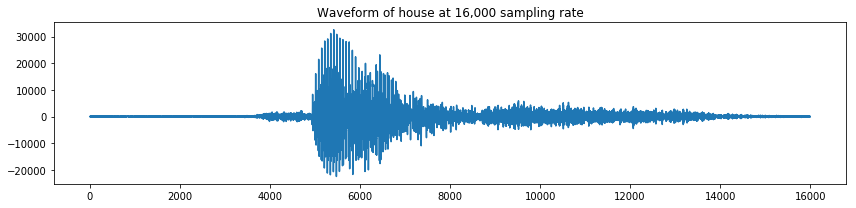

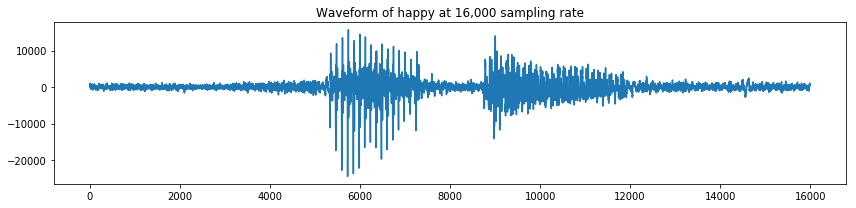

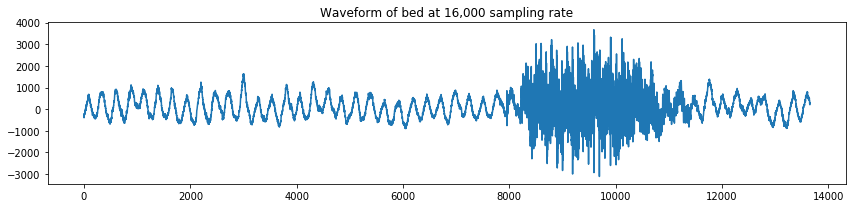

In [74]:
#plot the waveforms
for index, sample in enumerate(samples):
    fname =  os.path.split(sample) 
    plt.figure(figsize=(12,3))
    sample_rate, audio = wavfile.read(sample)
    ipd.display(ipd.Audio(audio, rate=sample_rate))    
    plt.plot(audio)
    plt.title('Waveform of {} at 16,000 sampling rate'.format(fname[0].split('/')[1]))
    plt.tight_layout()
    plt.show()


In [75]:
for sample in samples:     
    sample_rate, audio = wavfile.read(sample)
    model.make_predictions(sample, lbl_dir=DATA_PATH, max_len=30)
    ipd.display(ipd.Audio(audio, rate=sample_rate))

Model Predicted:  house


Model Predicted:  happy


Model Predicted:  bed


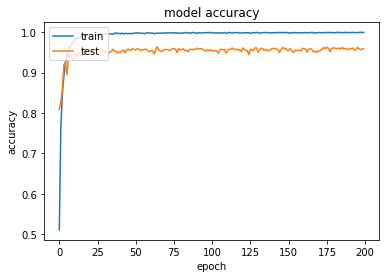

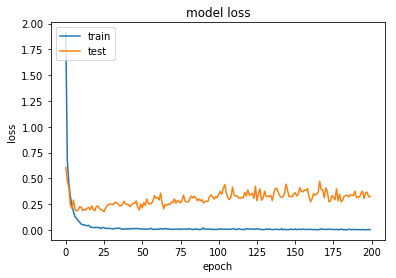

In [11]:
model.plot_accuracy()

In [13]:
def generate_spectrogram(audio_path):
    fname =  os.path.split(audio_path)    
    audio_raw, sampling_rate = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=audio_raw, sr=sampling_rate , n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(12,4))
    librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel')
    plt.title('mel power spectrogram: ' + fname[1])
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

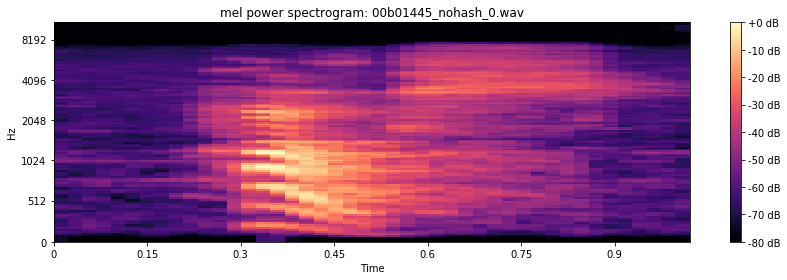

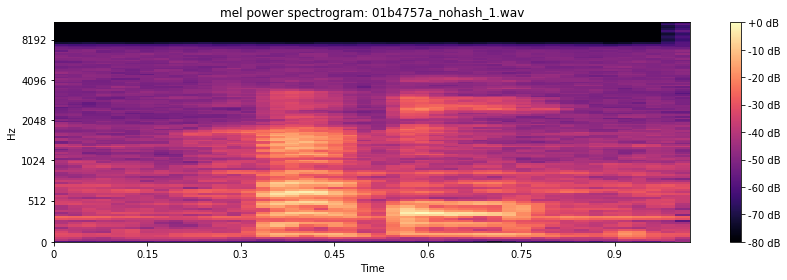

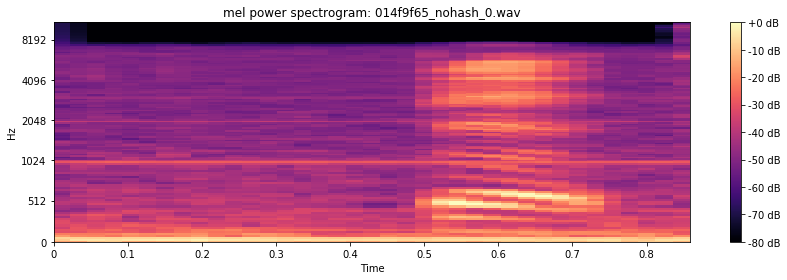

In [14]:
for sample in samples:    
    generate_spectrogram(sample)